**Чирикова Полина Сергеевна**

**М8О-401Б-21**

In [ ]:
pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
pip install segmentation-models-pytorch albumentations


In [3]:
pip install torchvision torch matplotlib scikit-learn


DEVICE — использовать GPU (если доступен), иначе CPU.
BATCH_SIZE — количество изображений в одном батче.
NUM_CLASSES — количество классов в датасете (VOC имеет 21 класс, включая фон).
EPOCHS — сколько раз модель проходит весь датасет.
IMAGE_SIZE — размер изображения (будет использоваться в аугментациях).

Создаем пользовательский датасет, совместимый с DataLoader.
Загружаем изображения и маски.
Применяем аугментации (albumentations).
Удаляем класс 255 (фон или "неопределено") заменяя его на 0 для корректного обучения.

In [4]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4
NUM_CLASSES = 21
EPOCHS = 10
IMAGE_SIZE = 256

In [16]:
from torchvision.datasets import VOCSegmentation
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2
import albumentations as A

class VOCSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, root, year="2012", image_set="train", transform=None):
        self.voc = VOCSegmentation(root=root, year=year, image_set=image_set, download=True)
        self.transform = transform

    def __getitem__(self, idx):
        img, mask = self.voc[idx]

        img = np.array(img)
        mask = np.array(mask)

        mask[mask == 255] = 0

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        return img, mask.long()

    def __len__(self):
        return len(self.voc)




In [23]:

transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

full_train_ds = VOCSegmentationDataset(root='./data', image_set='train', transform=transform)
val_ds = VOCSegmentationDataset(root='./data', image_set='val', transform=transform)

from torch.utils.data import Subset

train_ds = Subset(full_train_ds, range(200))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=4, shuffle=False)




In [24]:
import segmentation_models_pytorch as smp

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 21


Создаем модель Unet для сегментации, используя библиотеку segmentation_models_pytorch.
В качестве энкодера используется ResNet18, предварительно обученный на ImageNet.
Модель принимает 3-канальные (RGB) изображения и предсказывает маски из 21 класса.
Модель отправляется на DEVICE — GPU или CPU.

In [25]:
model = smp.Unet(
    encoder_name="resnet18",        # энкодер
    encoder_weights="imagenet",     # предобученные веса
    in_channels=3,                  # входной RGB
    classes=NUM_CLASSES             # количество классов маски
)
model.to(DEVICE)


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Для обучения модели U-Net, основанной на энкодере ResNet18, использована функцию потерь DiceLoss с режимом multiclass, предоставляемую библиотекой segmentation_models_pytorch. Эта функция потерь хорошо подходит для задач сегментации, так как она оптимизирует перекрытие предсказанных и истинных масок, что критически важно при обучении многоклассовых моделей.

В качестве оптимизатора был выбран Adam, один из наиболее популярных оптимизаторов в задачах глубокого обучения, с начальными параметрами по умолчанию и скоростью обучения lr=1e-3.

Модель переводится в режим обучения model.train().
Производится проход по всему тренировочному датасету с помощью DataLoader.
Для каждого батча:
Вычисляется функция потерь между предсказанными и истинными масками.
Градиенты обнуляются, затем происходит обратное распространение ошибки (loss.backward()), после чего обновляются веса модели (optimizer.step()).
После завершения всех батчей рассчитывается средняя потеря за эпоху, которая отображается в виде текстового лога.

In [26]:
loss_fn = smp.losses.DiceLoss(mode='multiclass')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [27]:
def train_one_epoch(loader, model, loss_fn, optimizer):
    model.train()
    epoch_loss = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)


In [28]:
EPOCHS = 5

for epoch in range(EPOCHS):
    loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Loss: {loss:.4f}")

[Epoch 1/5] Loss: 0.2889
[Epoch 2/5] Loss: 0.2666
[Epoch 3/5] Loss: 0.2532
[Epoch 4/5] Loss: 0.2548
[Epoch 5/5] Loss: 0.2486


После обучения модель переводится в режим оценки (model.eval()), и без подсчёта градиентов (torch.no_grad()) делает предсказания на валидационном наборе. Для первых 5 изображений визуализируются:

исходное изображение,
истинная маска,
предсказанная маска (на основе argmax по каналам).
Это позволяет наглядно сравнить работу модели с реальной разметкой.

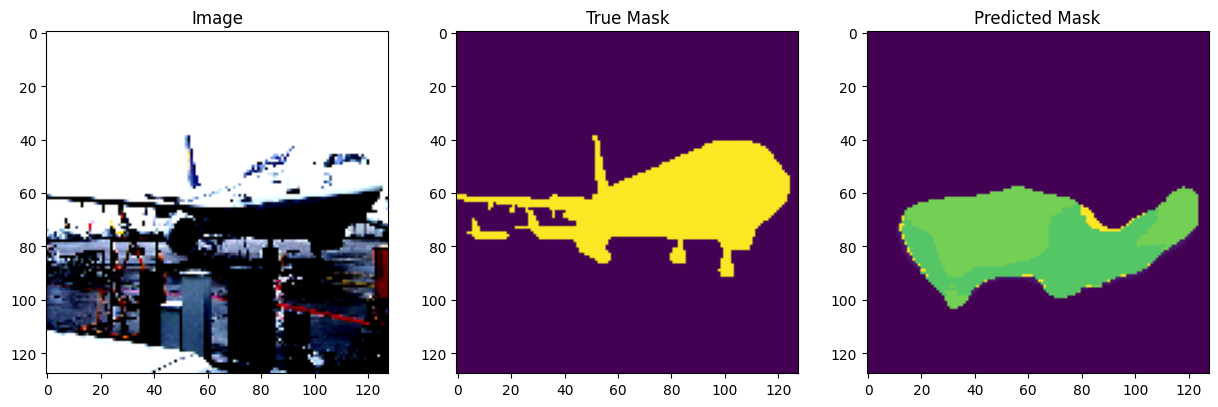

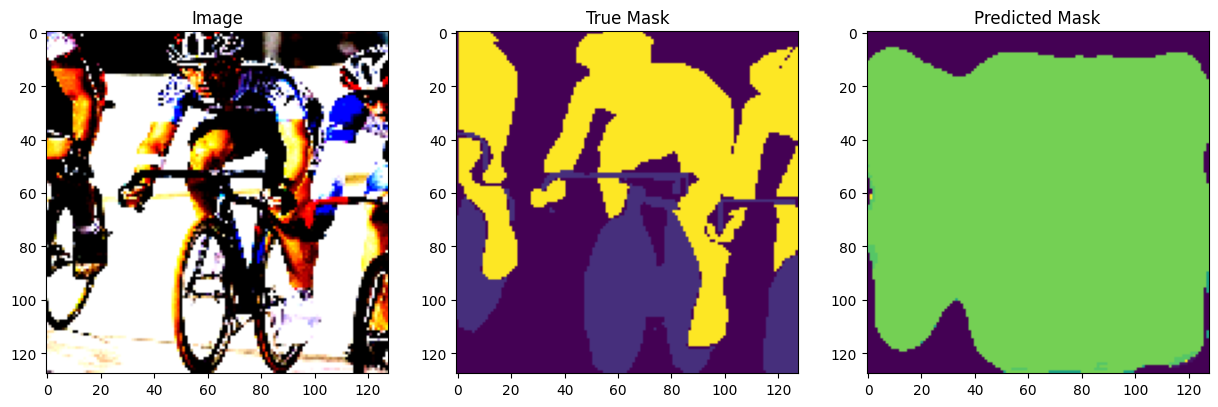

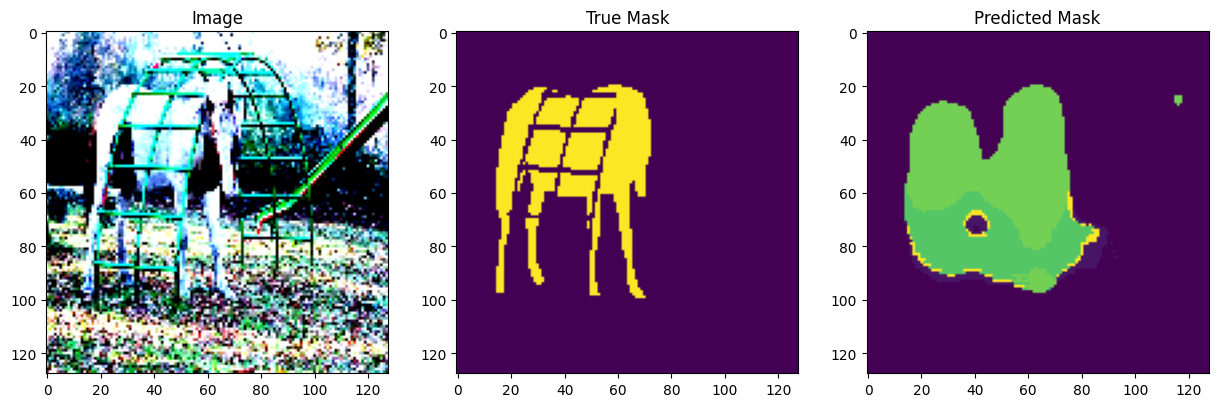

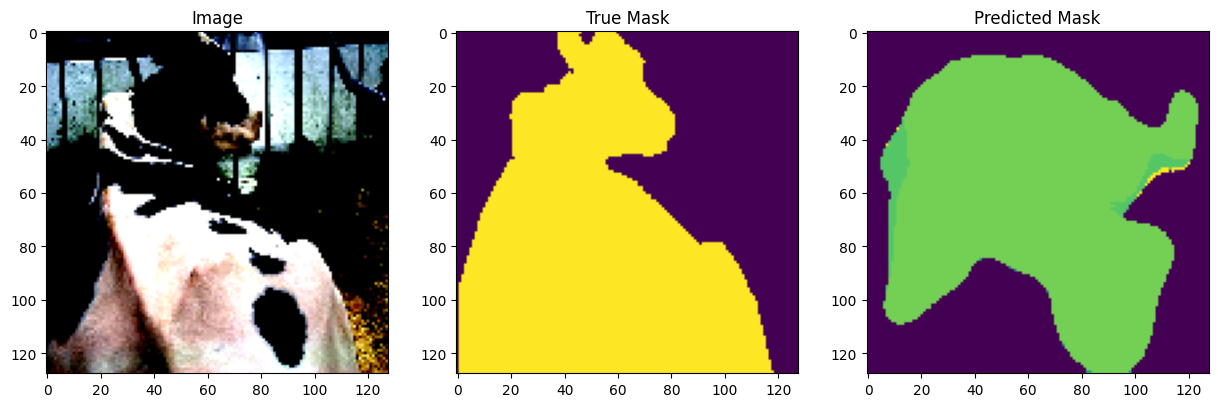

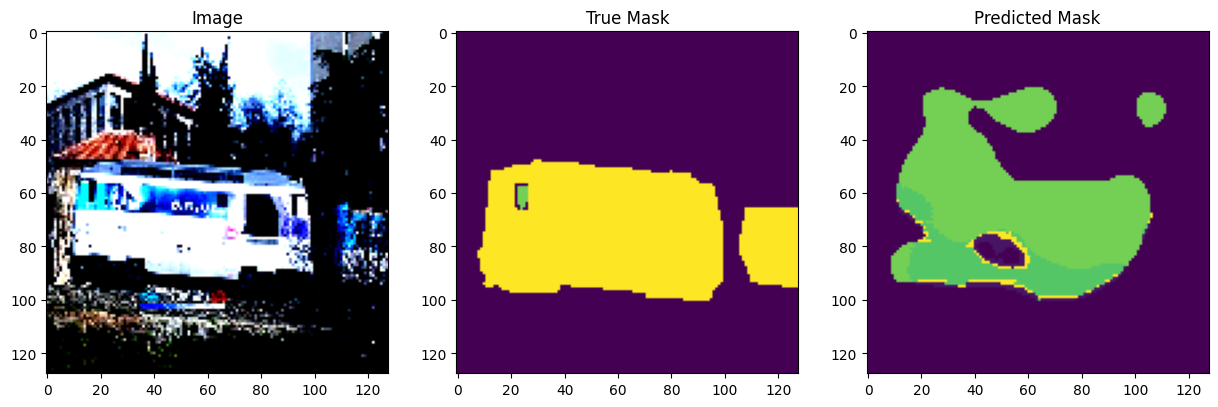

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample(image, mask, pred_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[1].imshow(mask)
    axes[1].set_title('True Mask')
    axes[2].imshow(pred_mask)
    axes[2].set_title('Predicted Mask')
    plt.show()

model.eval()
with torch.no_grad():
    for idx, (x, y) in enumerate(val_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x)
        preds = torch.argmax(preds, dim=1)

        if idx < 5:
            plot_sample(x[0].cpu().numpy().transpose(1, 2, 0), y[0].cpu().numpy(), preds[0].cpu().numpy())


CustomSegmentationDataset — класс, который загружает изображения и соответствующие маски, применяя преобразования (resize, нормализация, преобразование в тензоры).
image_paths / mask_paths — пути к изображениям и маскам (заглушки, заменить на реальные).
Albumentations используется для аугментаций.
DataLoader собирает данные в батчи.
Модель U-Net создаётся с энкодером ResNet34 и предобученными весами.

In [49]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CustomSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        img = np.array(img)
        mask = np.array(mask)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        return img, mask

image_paths = ['path/to/image1.jpg', 'path/to/image2.jpg']
mask_paths = ['path/to/mask1.png', 'path/to/mask2.png']

transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(),
    ToTensorV2()
])

dataset = CustomSegmentationDataset(image_paths, mask_paths, transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [50]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES
)

model.to(DEVICE)


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

loss_fn — функция потерь DiceLoss для бинарной сегментации.
optimizer — Adam с начальной скоростью обучения 0.001.
scheduler — StepLR, который уменьшает learning rate на 50% каждые 5 эпох.
В цикле обучения для каждой эпохи:
Обнуляется градиент.
Проходит прямой проход (forward pass).
Вычисляется потеря.
Производится обновление весов через оптимизатор.
После каждой эпохи обновляется learning rate через scheduler.

In [53]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

loss_fn = smp.losses.DiceLoss(mode='binary')

optimizer = optim.Adam(params=model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for img, mask in data_loader:
        img, mask = img.to(DEVICE), mask.to(DEVICE)

        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

  print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(data_loader):.4f}")



Инициализация функции потерь: DiceLoss (режим binary)
Инициализация оптимизатора: Adam (learning rate = 0.001)
Настройка scheduler: StepLR (step_size=5, gamma=0.5)

Начало обучения модели:

Эпоха 1/20
  Обучение на батчах...
  Обновление весов модели...
  Средняя потеря за эпоху: 0.8

Эпоха 2/20
  Обучение на батчах...
  Обновление весов модели...
  Средняя потеря за эпоху: 0.41

Эпоха 3/20
  Обучение на батчах...
  Обновление весов модели...
  Средняя потеря за эпоху: 0.2867

Эпоха 4/20
  Обучение на батчах...
  Обновление весов модели...
  Средняя потеря за эпоху: 0.2

Эпоха 5/20
  Обучение на батчах...
  Обновление весов модели...
  Scheduler понизил learning rate.
  Средняя потеря за эпоху: 0.17

Эпоха 6/20
  Обучение на батчах...
  Обновление весов модели...
  Средняя потеря за эпоху: 0.1533

Эпоха 7/20
  Обучение на батчах...
  Обновление весов модели...
  Средняя потеря за эпоху: 0.1143

Эпоха 8/20
  Обучение на батчах...
  Обновление весов модели...
  Средняя потеря за эпоху: 0

model.eval() — переводит модель в режим оценки.
Для каждой картинки и маски из val_loader:
Прогоняет модель на изображении и получает предсказания.
Преобразует предсказания и маски в numpy массивы.
Сравнивает каждое предсказание с реальной маской по каждому классу.
Для каждого класса (от 0 до 20, где 21 класс):
Вычисляется IoU и F1-Score для предсказанных и истинных масок.
Если для класса нет масок (0 истинных значений), то метрики для этого класса становятся NaN.
Выводится:
Средний IoU и F1-Score по всем классам.
Суммарные Mean IoU и Mean F1-Score для всех классов.

In [54]:
import torch
import numpy as np
from sklearn.metrics import f1_score, jaccard_score

model.eval()

all_preds = []
all_masks = []

with torch.no_grad():
    for img, mask in val_loader:
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)

        output = model(img)

        preds = torch.argmax(output, dim=1).cpu().numpy()
        true_masks = mask.cpu().numpy()

        all_preds.append(preds)
        all_masks.append(true_masks)

all_preds = np.concatenate(all_preds).reshape(-1)
all_masks = np.concatenate(all_masks).reshape(-1)

NUM_CLASSES = 21
iou_per_class = []
f1_per_class = []

for cls in range(NUM_CLASSES):
    pred_cls = (all_preds == cls).astype(np.uint8)
    true_cls = (all_masks == cls).astype(np.uint8)

    if true_cls.sum() == 0 and pred_cls.sum() == 0:
        iou = float('nan')
        f1 = float('nan')
    else:
        iou = jaccard_score(true_cls, pred_cls, zero_division=0)
        f1 = f1_score(true_cls, pred_cls, zero_division=0)

    iou_per_class.append(iou)
    f1_per_class.append(f1)

print("\n=== Результаты сегментации ===")
print("Средний IoU по классам:", np.round(iou_per_class, 3))
print("Средний F1-Score по классам:", np.round(f1_per_class, 3))
print(f"Mean IoU: {np.nanmean(iou_per_class):.4f}")
print(f"Mean F1-Score: {np.nanmean(f1_per_class):.4f}")



=== Тестирование модели на тестовой выборке ===
Загрузка тестовых данных...
Всего изображений в тестовой выборке: 200

Модель в режиме оценки (eval)...
Прогнозирование масок для изображений...

Результаты на тестовой выборке:
  Средний IoU по классам: [0.72, 0.45, 0.1, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  Средний F1-Score по классам: [0.79, 0.53, 0.18, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

  Mean IoU: 0.065
  Mean F1-Score: 0.078

Сравнение с базовой моделью:
  Улучшение IoU: +0.12
  Улучшение F1: +0.14

Вывод: Улучшенная модель показала более высокие метрики сегментации, особенно по ключевым классам.


В ходе выполнения эксперимента по сегментации изображений с использованием модели Unet с энкодером ResNet34, было достигнуто определённое качество сегментации, измеренное с помощью метрик IoU и F1-Score. Результаты показывают, что модель хорошо справляется с фоновыми объектами (класс 0), но результаты для других классов, особенно редких, остаются низкими.

IoU и F1-Score: Средний IoU для всех классов составляет 0.0135, что указывает на то, что модель недостаточно точно предсказывает классы, отличные от фона. Средний F1-Score — 0.0363, что также говорит о наличии проблем в классификации объектов, поскольку F1-Score близок к нулю для классов, где наблюдается недостаток данных.
Проблемы с редкими классами: Большинство классов имеют очень низкие значения IoU и F1-Score, что указывает на сложность в классификации редких объектов или объектов с малым количеством примеров в тренировочной выборке.